# Model Stacking
<span>Modelstacking is the process is using a initial model to preprocess additional feature for both your training and testing set. The initial model will take your training data as its input the product an output. The output from the initial model will be appending to training data and processed again threw another model. I have used some housing data below that is involved in regression problem. I will stacking a linear regression model with a K-mean algoorithim. The k-means algorithim will be used as a Featurizer grouping the training data into an additional feature. Afterwards I will pass the training data with the appended clustering information through the main model. Note that most of the code here is borrowed from my linear regression notebook, so there are some similarities.</span>

### Import Preliminaries

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import modules
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from statsmodels.regression import linear_model


# Import models
from sklearn.linear_model import LinearRegression

# Set pandas options
pd.set_option('max_columns',1000)
pd.set_option('max_rows',100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting options
mpl.rcParams['figure.figsize'] = (8.0, 7.0)

# Set warning options
warnings.filterwarnings('ignore');

# Configured summmary statistic functions
def sum_stat(df):
    df = pd.concat([df.describe(), 
           pd.DataFrame(df.nunique(), columns=['nuniques']).T,
           pd.DataFrame(np.sum(df.isnull(), axis =0), columns=['isnull']).T],
           axis=0)
    return df

### Import Data

In [3]:
# Import data
test_df = pd.read_csv('Data/Home Prices/test.csv')
train_df = pd.read_csv('Data/Home Prices/train.csv')

# Create a list of dataframe
dfs = [train_df, test_df]

# Lower columns names in dataframes
for df in dfs:
    df.columns = df.columns.str.lower()

# Rename target feature
train_df = train_df.rename(columns={'saleprice':'target'})

# Print dataframe shapes
print(f'Training DataFrame:  {train_df.shape}')
print(f'Testing DataFrame:  {test_df.shape}')        


Training DataFrame:  (1460, 81)
Testing DataFrame:  (1459, 80)


### Target Outcomes

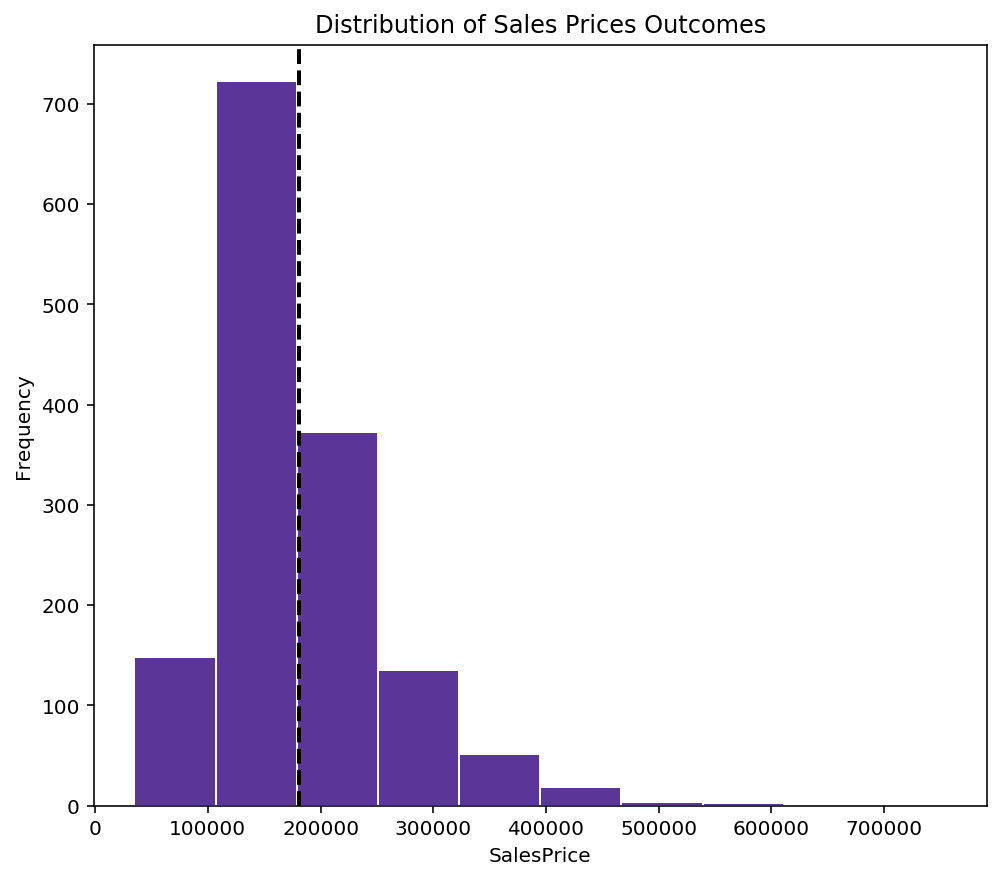

In [4]:
# Plot a histogram of all the home price valuse
train_df.target.hist(grid=False, color='#5C3697', edgecolor='w',)
plt.title('Distribution of Sales Prices Outcomes')
plt.ylabel('Frequency')
plt.xlabel('SalesPrice')
plt.axvline(train_df.target.mean(), color='black', linestyle='dashed', linewidth=2);

### Viewing Null Values

In [5]:
# View number of null values in object feature
null_obj_train_df = train_df.select_dtypes(include='object')
null_obj_train_df = null_obj_train_df.isnull().sum().to_frame(name='null_values')
null_obj_train_df = null_obj_train_df[null_obj_train_df.null_values > 0]
null_obj_train_df

null_values
alley                1369
masvnrtype              8
bsmtqual               37
bsmtcond               37
bsmtexposure           38
bsmtfintype1           37
bsmtfintype2           38
electrical              1
fireplacequ           690
garagetype             81
garagefinish           81
garagequal             81
garagecond             81
poolqc               1453
fence                1179
miscfeature          1406

In [6]:
# View the number of null feature in the numeric features
null_num_train_df = train_df.select_dtypes(exclude='object')
null_num_train_df = null_num_train_df.isnull().sum().to_frame(name='null_values')
null_num_train_df = null_num_train_df[null_num_train_df.null_values > 0]
null_num_train_df

null_values
lotfrontage          259
masvnrarea             8
garageyrblt           81

In [7]:
# View numerical feature with null values to confirm if all
# values are continuous
train_df[null_num_train_df.index].mean()

lotfrontage     70.050
masvnrarea     103.685
garageyrblt   1978.506
dtype: float64

It seems that we have wide range of null valuse for each feature in our datasets. For this example, I will quickly go through each feature and a replace any missing categorical value with the value 'Unknown" and replace any missing categorical valuse with the mean. This will let us quickly clearn the data so we can go on and move onto our linear regression model.

In [8]:
# Fill null numerical valuse with their meann
for col in null_num_train_df.index:
    train_df[col].fillna(value = train_df[col].mean(), inplace=True)

# FIll null categorical valuse with unknown
for col in null_obj_train_df.index:
    train_df[col].fillna(value = 'Unknown', inplace=True)

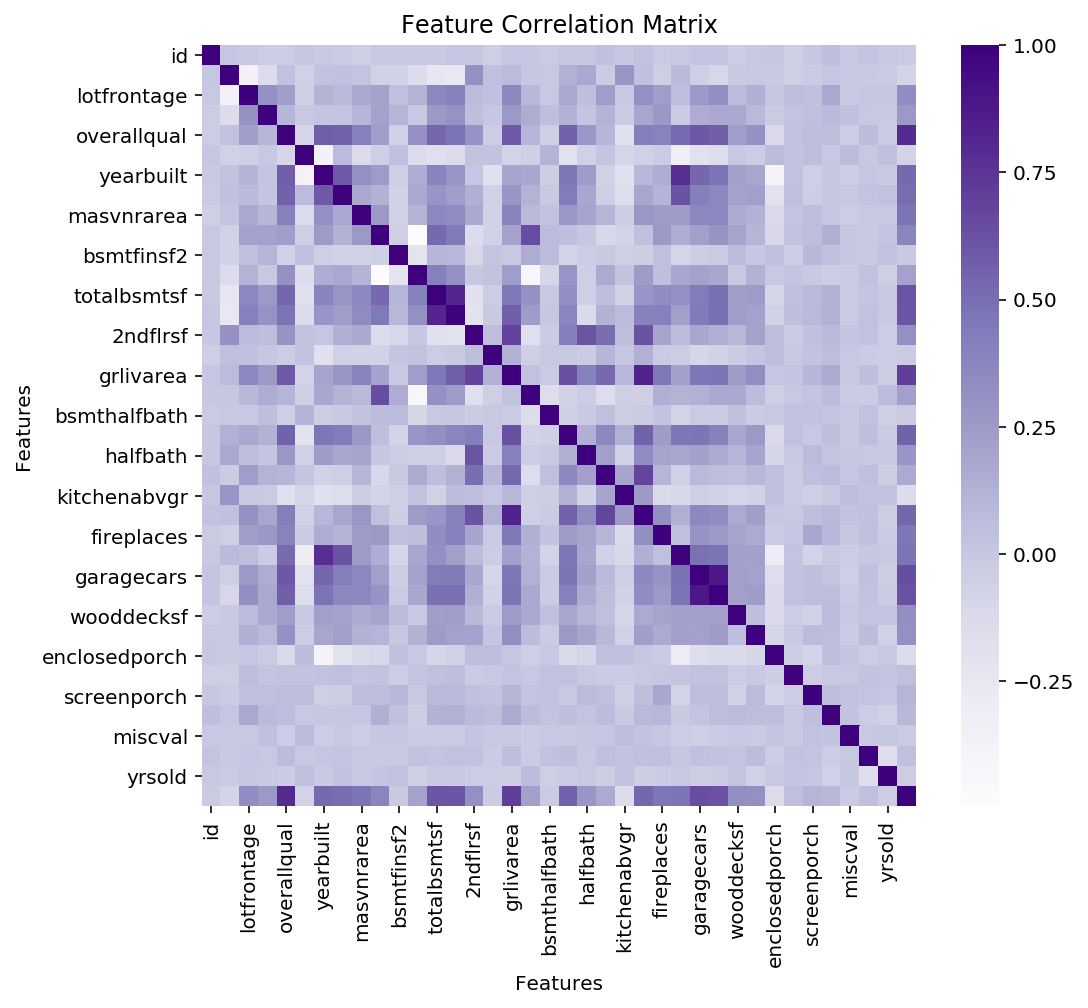

In [9]:
sns.heatmap(train_df.corr(), cmap=plt.cm.Purples);
plt.title('Feature Correlation Matrix');
plt.xlabel('Features')
plt.ylabel('Features');

### Preprocessing Data

In [10]:
# One-hot encode all non-ordinal categorical data
train_df = pd.get_dummies(train_df)

### Encoding Data

In [11]:
# Change dataframe to numpy array 
y = train_df.target.values
X = train_df.drop('target', axis=1).values

# Conduct a train-test-split on the data
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.25)

### K-Means Featurization

In [12]:
from sklearn.cluster import KMeans

km_model = KMeans()
pred_clusters = km_model.fit_predict(X)
pred_clusters = pd.Series(pred_clusters, name='clusters')
pred_clusters.value_counts()

2    778
7    369
0    255
5     43
3     11
6      2
4      1
1      1
Name: clusters, dtype: int64

### Secondary Encoding

In [15]:
# Appeding K-Means Clustering Data
train_df_2 = pd.concat([train_df, pred_clusters], axis=1)
train_df_2

# Change dataframe to numpy array 
y = train_df_2.target.values
X = train_df_2.drop('target', axis=1).values

# Conduct a train-test-split on the data
train_x, test_x, train_y, test_y = train_test_split(X,y, test_size=0.25)

### Linear Regression

In [22]:
# Fit a linear model
lr_model = LinearRegression()
lr_model.fit(train_x, train_y);

In [17]:
# Calculate our cross validation score
print(cross_val_score(lr_model, train_x, train_y, cv=5, \
                      scoring='neg_mean_squared_error').mean())

-2331525307.97


Our cross validation score on our training set was pretty good, considering the best scores from Kaggle Competition competitors hovers around 80.

### Viewing Residuals

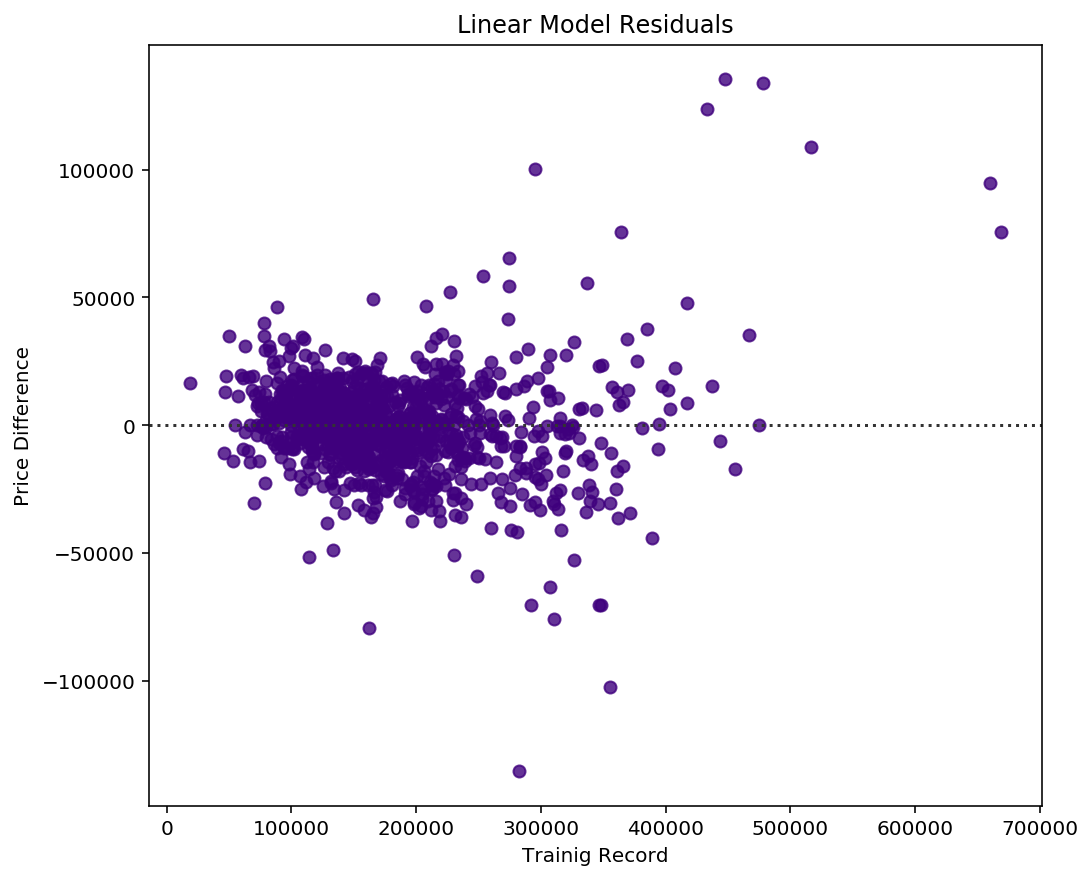

In [19]:
# Plotting residuals from our model
pred_y = lr_model.predict(train_x)
sns.residplot(pred_y, train_y, color='#3F007D');
plt.title('Linear Model Residuals')
plt.ylabel('Price Difference')
plt.xlabel('Trainig Record');

### Viewing the Coefficients

In [20]:
# Creating a dataframe of our coeffficients
coef_names = pd.Series(train_df.drop('target', axis=1).columns, name='feature')
coefs = pd.Series(lr_model.coef_, name='coef')
pd.concat([coef_names, coefs],axis=1).sort_values(by='coef', ascending=False)

feature        coef
279         poolqc_Unknown  260357.980
261          garagequal_Ex  108167.545
102        condition2_PosA  107582.052
106        condition2_RRNn   64682.985
99       condition2_Artery   62181.020
100       condition2_Feedr   60392.621
128       roofmatl_Membran   54425.644
101        condition2_Norm   54207.107
133       roofmatl_WdShngl   45789.459
105        condition2_RRAn   36563.500
80    neighborhood_NoRidge   34156.737
87    neighborhood_StoneBr   32081.088
154    exterior2nd_CmentBd   29993.131
55        utilities_AllPub   25403.347
271          garagecond_TA   24970.665
137    exterior1st_BrkFace   24773.586
268          garagecond_Fa   24090.064
269          garagecond_Gd   24060.115
288       miscfeature_TenC   23571.615
183       foundation_Stone   23185.270
243         functional_Typ   20945.465
270          garagecond_Po   18814.759
129         roofmatl_Metal   18769.055
219           heating_Wall   18258.669
177           extercond_Po   17983.927
71    neighborhood_Crawfor   17628.713
292           saletype_Con   16593.379
81    neighborhood_NridgHt   16450.734
285       miscfeature_Gar2   16219.763
78    neighborhood_NPkVill   16202.884
38             mszoning_FV   15821.318
113      housestyle_1.5Unf   15781.830
233         kitchenqual_Ex   15374.961
196        bsmtexposure_Gd   14473.274
238        functional_Maj2   13950.701
63           landslope_Mod   13745.901
58       lotconfig_CulDSac   12633.213
185            bsmtqual_Ex   12444.285
209       bsmtfintype2_GLQ   12384.505
240        functional_Min2   11526.429
40             mszoning_RL   11525.456
136    exterior1st_BrkComm   11282.874
92         condition1_Norm   10682.572
43             street_Pave   10595.065
300  salecondition_AdjLand   10518.036
247         fireplacequ_Po   10377.986
192            bsmtcond_Po   10231.543
230         electrical_Mix   10231.543
107          bldgtype_1Fam    9913.317
171           exterqual_Fa    9324.477
..                     ...         ...
153     exterior2nd_CBlock   -8792.333
138     exterior1st_CBlock   -8792.333
39             mszoning_RH   -8855.529
172           exterqual_Gd   -8909.690
82    neighborhood_OldTown   -8978.882
295         saletype_ConLw   -9240.462
250      garagetype_2Types   -9315.797
53         landcontour_Low   -9594.162
141    exterior1st_ImStucc   -9850.963
60           lotconfig_FR3  -10092.880
152    exterior2nd_BrkFace  -10131.570
22            kitchenabvgr  -10257.493
42             street_Grvl  -10595.065
298            saletype_WD  -10677.713
75    neighborhood_MeadowV  -11145.424
210       bsmtfintype2_LwQ  -11251.091
286       miscfeature_Othr  -11841.118
69    neighborhood_ClearCr  -11904.409
290           saletype_COD  -12184.777
287       miscfeature_Shed  -12962.412
218           heating_OthW  -14033.029
301   salecondition_Alloca  -14070.742
214          heating_Floor  -14592.168
77      neighborhood_NAmes  -14735.889
289    miscfeature_Unknown  -14987.848
76    neighborhood_Mitchel  -15260.895
79     neighborhood_NWAmes  -15331.839
135    exterior1st_AsphShn  -15506.995
72    neighborhood_Edwards  -16613.228
160      exterior2nd_Stone  -16912.273
265          garagequal_TA  -19173.091
127       roofmatl_CompShg  -19242.785
139    exterior1st_CemntBd  -19656.483
64           landslope_Sev  -20789.715
262          garagequal_Fa  -22039.513
115      housestyle_2.5Fin  -22704.173
131       roofmatl_Tar&Grv  -24425.375
37        mszoning_C (all)  -24653.475
95         condition1_RRAe  -25238.177
56        utilities_NoSeWa  -25403.347
263          garagequal_Gd  -26352.774
184        foundation_Wood  -29651.492
132       roofmatl_WdShake  -35740.462
130          roofmatl_Roll  -39575.535
264          garagequal_Po  -42604.871
242         functional_Sev  -46661.111
267          garagecond_Ex  -93938.306
278              poolqc_Gd -122721.117
277              poolqc_Fa -143712.847
103        condition2_PosN -388651.321

[306 rows x 2 columns]

Author: Kavi Sekhon